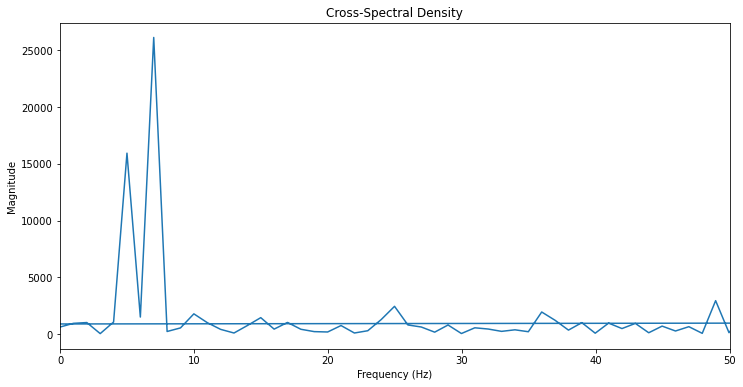

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Sample Data
np.random.seed(0)  # For reproducibility
n = 1000  # Number of data points
t = np.linspace(0, 1, n)  # Time vector
X = np.sin(2 * np.pi * 5 * t) + np.random.normal(0, 1, n)  # Signal X
Y = np.sin(2 * np.pi * 7 * t) + np.random.normal(0, 1, n)  # Signal Y

# Step 2: Compute Fourier Transforms
X_fft = np.fft.fft(X)
Y_fft = np.fft.fft(Y)
freq = np.fft.fftfreq(n, d=t[1] - t[0])  # Frequency vector

# Step 3: Calculate Cross-Spectral Density
cross_spectral_density = X_fft * np.conj(Y_fft)

# Optional: Plot the result
plt.figure(figsize=(12, 6))
plt.plot(freq, np.abs(cross_spectral_density))
plt.title('Cross-Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim([0, 50])  # Limit frequency range for better visibility
plt.show()


/tmp/ipykernel_128817/377241441.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


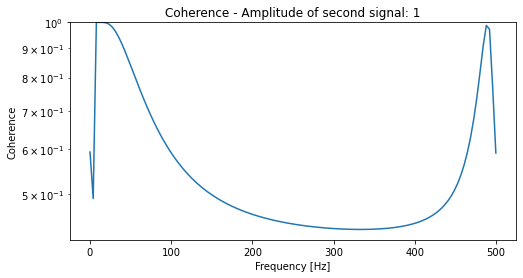

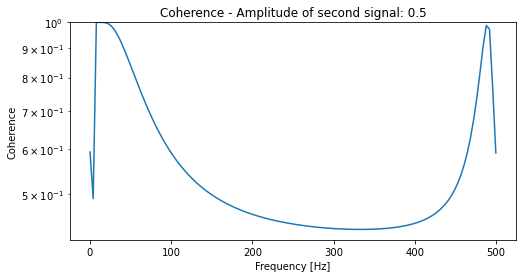

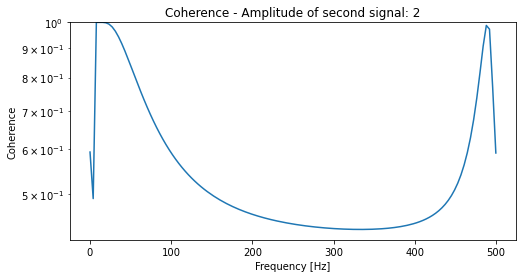

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence

# Sample rate and time vector
fs = 1000  # Sample rate in Hz
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second time vector

# Function to calculate and plot coherence
def plot_coherence(amplitude):
    # Signal with constant amplitude
    x = np.sin(2 * np.pi * 10 * t)

    # Signal with variable amplitude
    y = amplitude * np.sin(2 * np.pi * 10 * t + np.pi / 4)  # phase shift of 45 degrees

    # Calculate coherence
    f, Cxy = coherence(x, y, fs, nperseg=256)

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.semilogy(f, Cxy)
    plt.title(f'Coherence - Amplitude of second signal: {amplitude}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Coherence')
    plt.ylim([0, 1])
    plt.show()

# Plot coherence for different amplitudes
plot_coherence(1)  # Equal amplitude
plot_coherence(0.5)  # Reduced amplitude
plot_coherence(2)  # Increased amplitude


In [64]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
from mne.filter import filter_data
from scipy.signal import hilbert
import pickle
import mne_connectivity

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import sim functions
from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw
from neurodsp.utils import set_random_seed

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series


In [110]:
## funcions
class EpochsTFR:
    def __init__(self, data, times, freqs, info):
        self.data = data
        self.times = times
        self.freqs = freqs
        self.info = info

def compute_hilbert_phase(epochs, freqs, n_cycles, workers = 8):
    """ function to compute TFR phase via Hilbert transform
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')

    data = epochs.get_data()
    sfreq = epochs.info['sfreq']

    TFR_phase = da.empty((len(data), len(epochs.ch_names), len(freqs), len(epochs.times)))
    for f, freq in enumerate(freqs):
        l_freq = freq - freq / (2.0 * n_cycles[f])
        h_freq = freq + freq / (2.0 * n_cycles[f])
        # Filter data in each frequency band
        filtered_data = mne.filter.filter_data(data, sfreq, l_freq, h_freq, method='fir', phase='zero', verbose='WARNING', n_jobs=workers)
        filtered_data_da = da.from_array(filtered_data, chunks='auto')
        # Apply Hilbert transform to get the phase
        TFR_phase[:, :, f, :] = da.angle(da.map_blocks(hilbert, filtered_data_da, dtype=filtered_data_da.dtype, axis=2))

    return TFR_phase.compute()


    return EpochsTFR(TFR_phase, epochs.times, freqs, epochs.info)

def compute_mrl(phases):
    # Convert the Dask array to a NumPy array if necessary
    phases = da.from_array(phases, chunks='auto')  # chunks='auto' lets Dask choose the chunk size

    # Convert each phase to a unit vector on the circle
    unit_vectors = da.exp(1j*phases)

    # Compute the mean of these unit vectors along the trial axis
    mean_resultant_vector = da.mean(unit_vectors, axis=0)

    # Compute the mean resultant length (MRL) as the magnitude of the mean resultant vector
    mrl = da.abs(mean_resultant_vector)

    # At this point, mrl is a Dask array. To actually compute the MRL values and get a NumPy array, call .compute()
    mrl = mrl.compute()

    return mrl

def compute_itc(phases):
    # Convert the Dask array to a NumPy array if necessary
    phases = da.from_array(phases, chunks='auto')  # chunks='auto' lets Dask choose the chunk size

    # Compute the mean resultant length (MRL) as the magnitude of the mean resultant vector
    mrl = stats.circmean(phases)

    # At this point, mrl is a Dask array. To actually compute the MRL values and get a NumPy array, call .compute()
    mrl = mrl.compute()

    return mrl

  
def compute_coherence(epochs, ch_names, roi_index, freqs, n_cycles,  workers = 8):
    """ function to compute TFR via Morlet wavelets
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')
    connect = mne_connectivity.spectral_connectivity_epochs(data = epochs,
                                                            names = ch_names,
                                                            # method = ['coh', 'cohy', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'dpli', 'wpli', 'wpli2_debiased'],
                                                            method = ['imcoh'],
                                                            mode = 'cwt_morlet',
                                                            cwt_freqs = freqs,
                                                            cwt_n_cycles = n_cycles,
                                                            n_jobs = workers)
    return connect



In [4]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)

[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

## Fake Data

In [66]:
# Set the random seed, for consistency simulating data
set_random_seed(0)

# Set some general settings, to be used across all simulations
fs = 1000
n_seconds = 3
times = create_times(n_seconds, fs)


In [99]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                        'tau_r' : 0.002, 'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 5}}

component2 = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 3, 't_ker' : 1.0,
                                        'tau_r' : 0.005, 'tau_d' : 0.05},
              'sim_oscillation' : {'freq' : 5}}

In [105]:
for idx in range(n_epochs):
    set_random_seed(idx)
    eeg1[idx, :] = sim_combined(n_times/fs, fs, components)
    set_random_seed(idx)
    eeg2[idx, :] = sim_combined(n_times/fs, fs, component2)

In [106]:
# Parameters
n_epochs = 163  # Number of epochs
n_times = 32001   # Number of time points in each epoch
sfreq = 1000     # Sampling frequency in Hz

# Generate independent signal for EEG3
eeg3 = np.random.randn(n_epochs, n_times)

data = np.array([signal1, signal2, signal3])
data = np.transpose(data, (1, 0, 2))  # Transpose to shape (n_epochs, n_times, n_channels)

# Create Info object
ch_names = ['EEG1', 'EEG2', 'EEG3']
ch_types = ['eeg'] * 3
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create Epochs object
epochs = mne.EpochsArray(data, info)

print(epochs)

Not setting metadata
163 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray |  163 events (all good), 0 - 32 sec, baseline off, ~119.4 MB, data loaded,
 '1': 163>


In [12]:
data.shape

(3, 163, 32001)

In [15]:
roi_phase = []
roi_phase = compute_hilbert_phase(epochs,freqs,n_cycles)

computing TFR


In [16]:
roi_mrl = compute_mrl(roi_phase.data)

In [17]:
roi_mrl.shape

(3, 80, 32001)

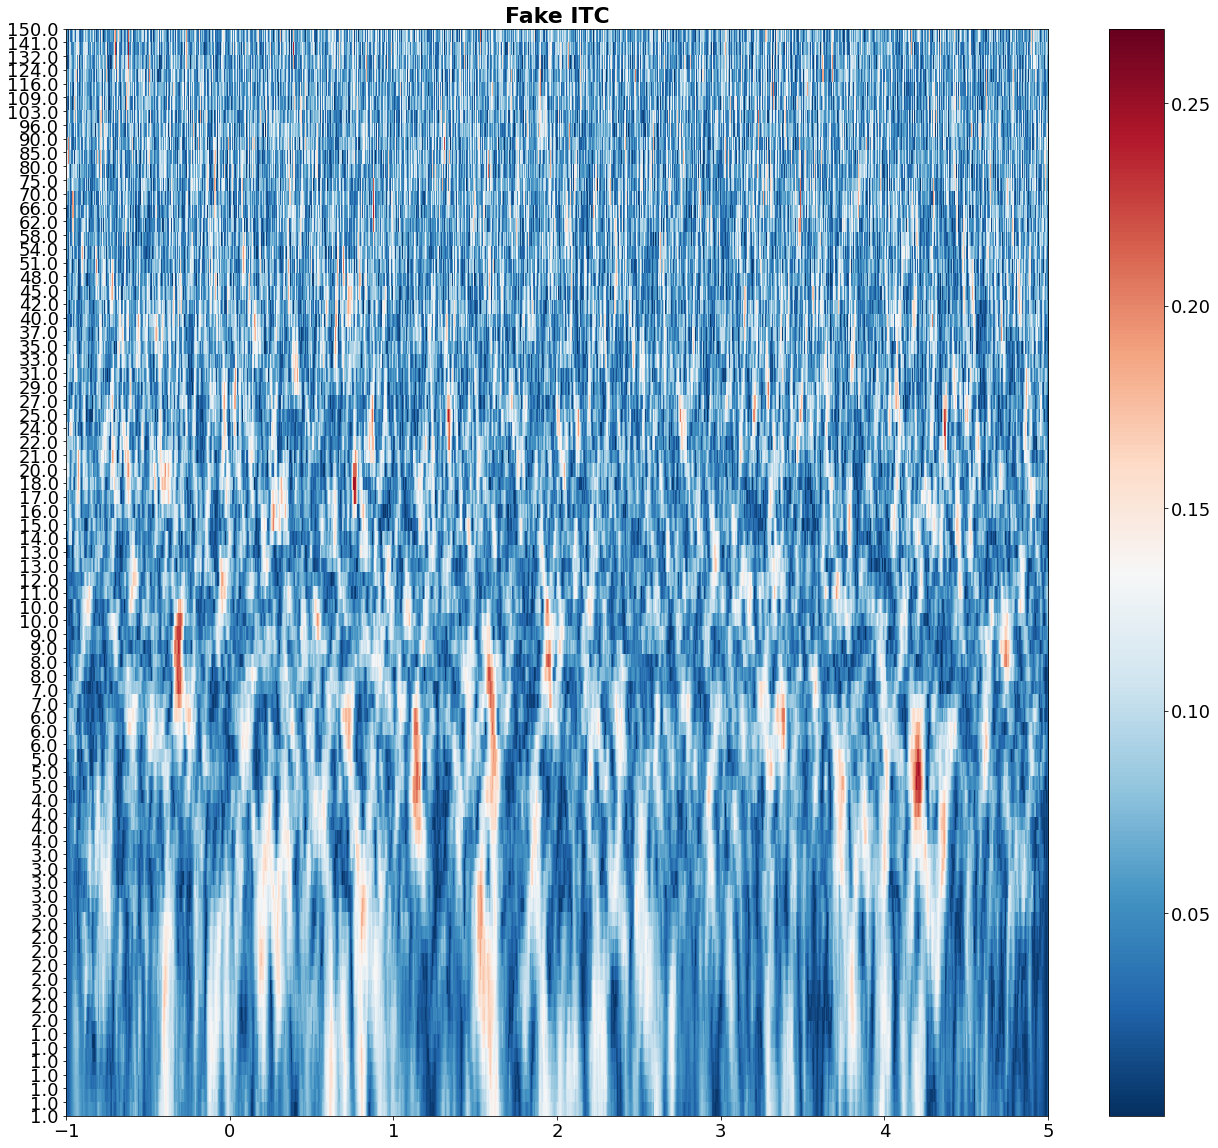

In [19]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})



fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_mrl[0], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Fake ITC", fontsize=22, fontweight = 'bold')
fig.show()

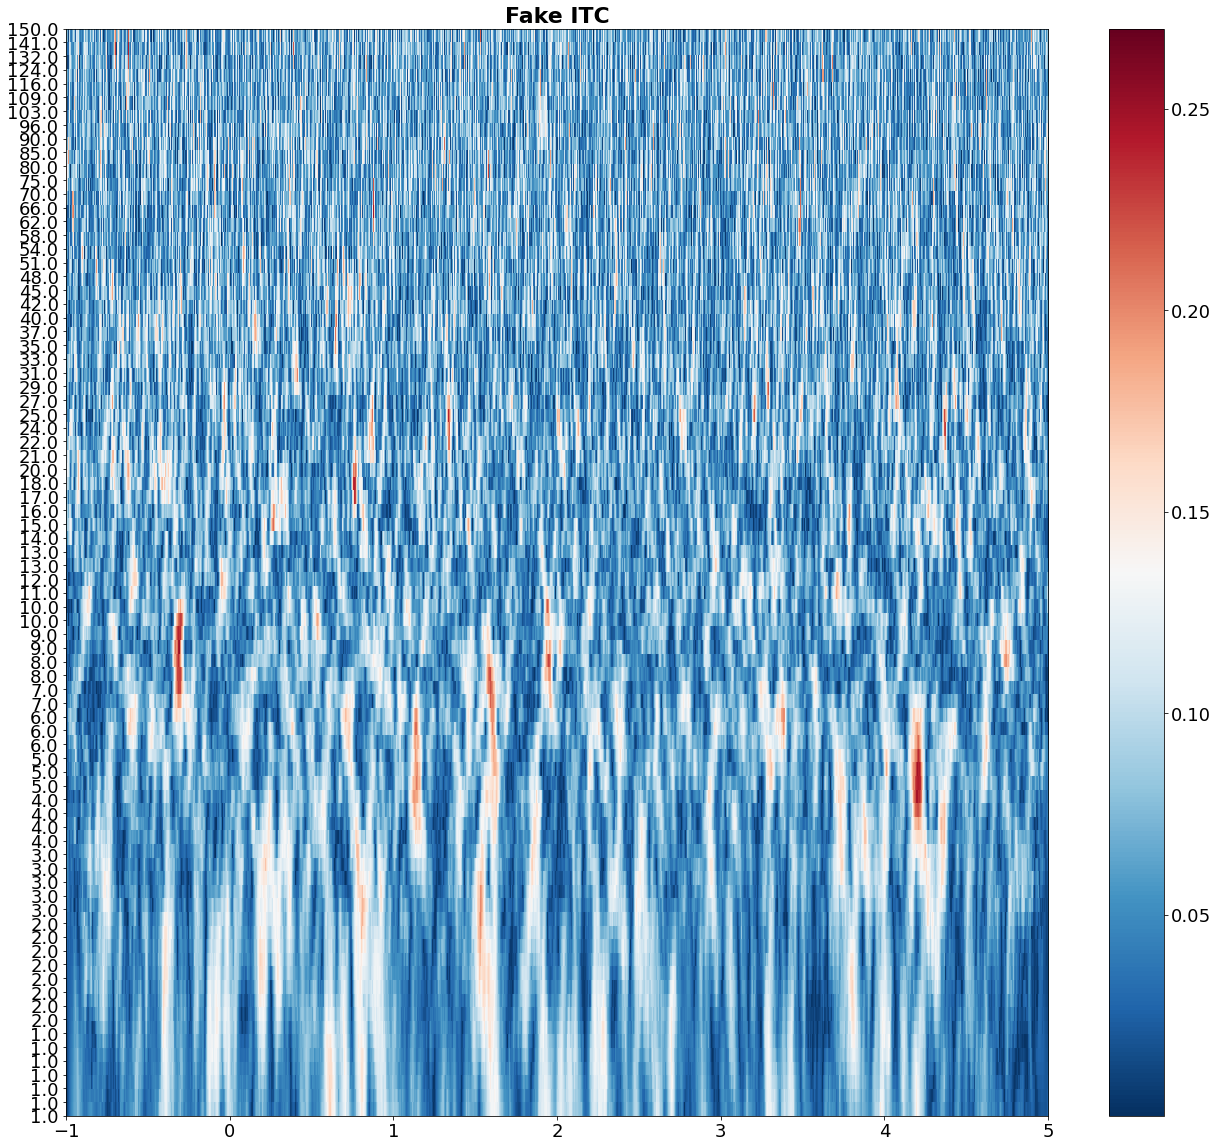

In [20]:
fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_mrl[1], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Fake ITC", fontsize=22, fontweight = 'bold')
fig.show()

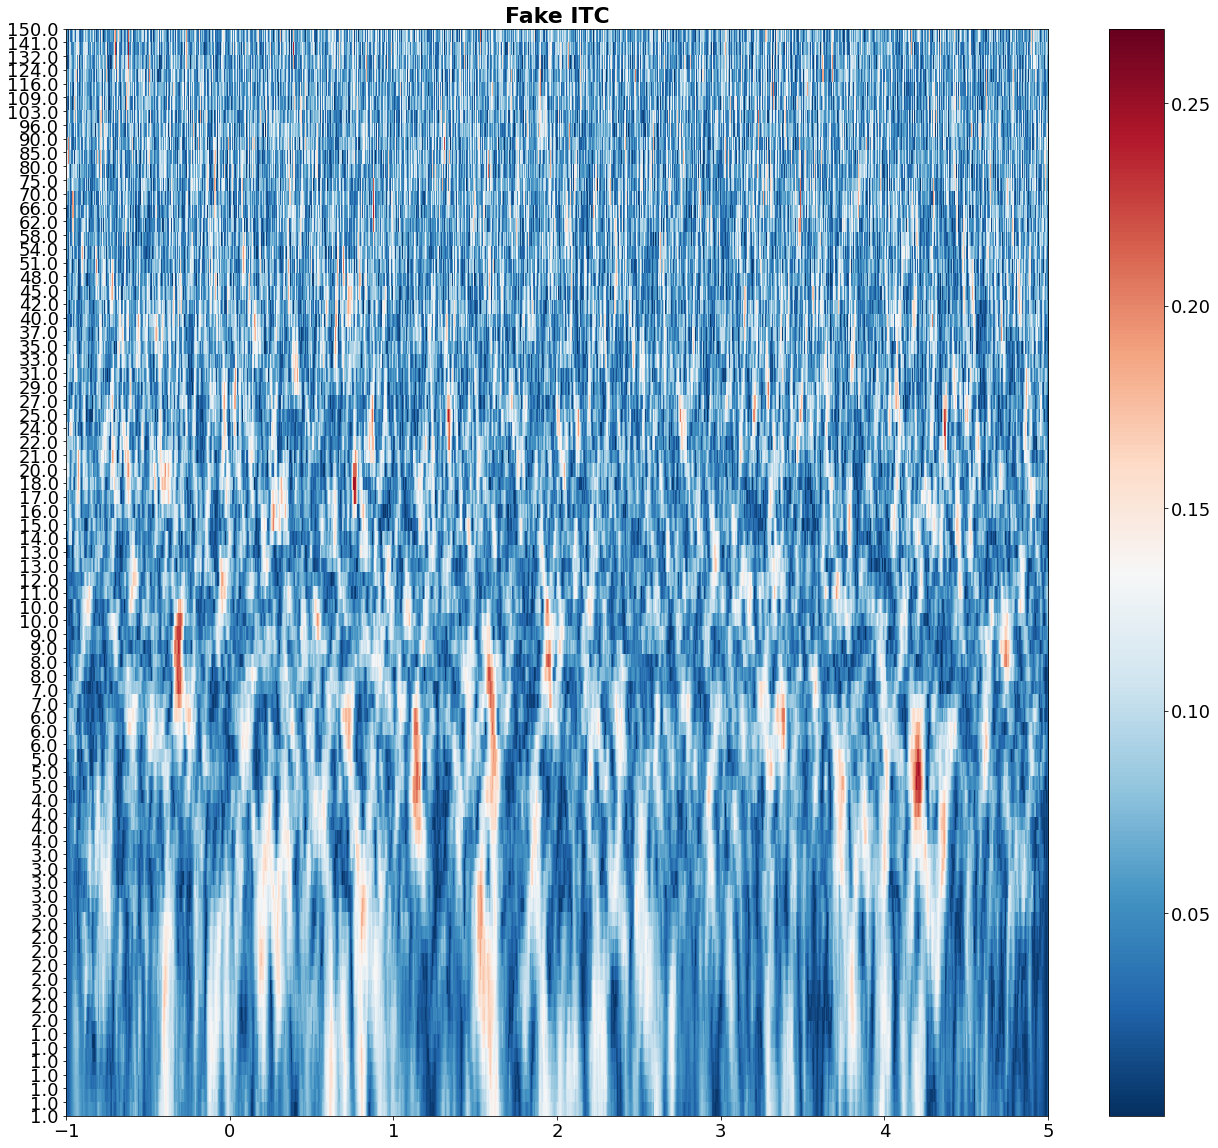

In [21]:
fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_mrl[0], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Fake ITC", fontsize=22, fontweight = 'bold')
fig.show()

## Fake Connectivity

In [35]:
epochs.info['ch_names']

['EEG1', 'EEG2', 'EEG3']

In [107]:
roi_coherence = compute_coherence(epochs,ch_names, 'all', freqs,n_cycles, workers = 8)

computing TFR
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 3 connections
    using t=0.000s..32.000s for estimation (32001 points)
    frequencies: 1.0Hz..150.0Hz (80 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Imaginary Coherence
    computing connectivity for epochs 1..8


/tmp/ipykernel_130796/1440339646.py:64: RuntimeWarning: There were no Annotations stored in <EpochsArray |  163 events (all good), 0 - 32 sec, baseline off, ~119.4 MB, data loaded,
 '1': 163>, so metadata was not modified.
  connect = mne_connectivity.spectral_connectivity_epochs(data = epochs,
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished


    computing connectivity for epochs 9..16


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.9s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished


    computing connectivity for epochs 17..24


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 25..32


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 33..40


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished


    computing connectivity for epochs 41..48


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 49..56


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 57..64


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 65..72


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 73..80


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 81..88


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 89..96


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished


    computing connectivity for epochs 97..104


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 105..112


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 113..120


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 121..128


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.1s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished


    computing connectivity for epochs 129..136


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.1s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished


    computing connectivity for epochs 137..144


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 145..152


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.1s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 153..160


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished


    computing connectivity for epochs 161..163


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.4s finished


    assembling connectivity matrix
[Connectivity computation done]


In [108]:
tmp = roi_coherence.get_data('dense')

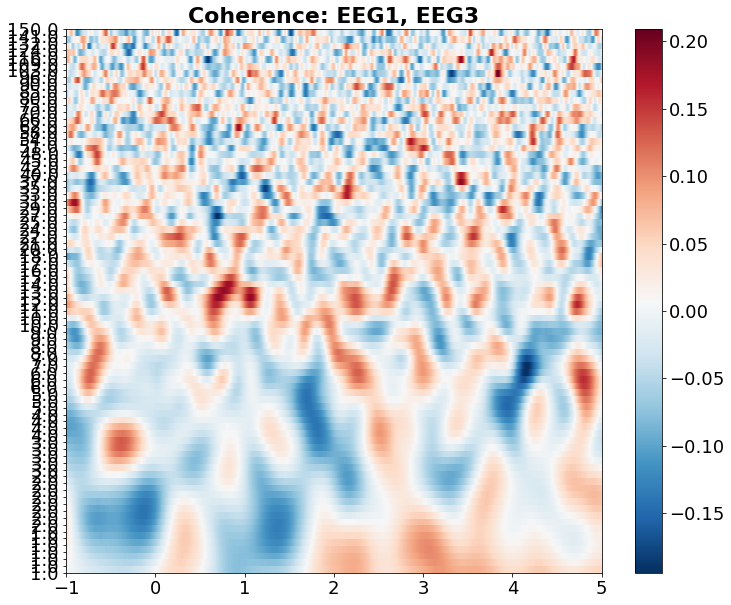

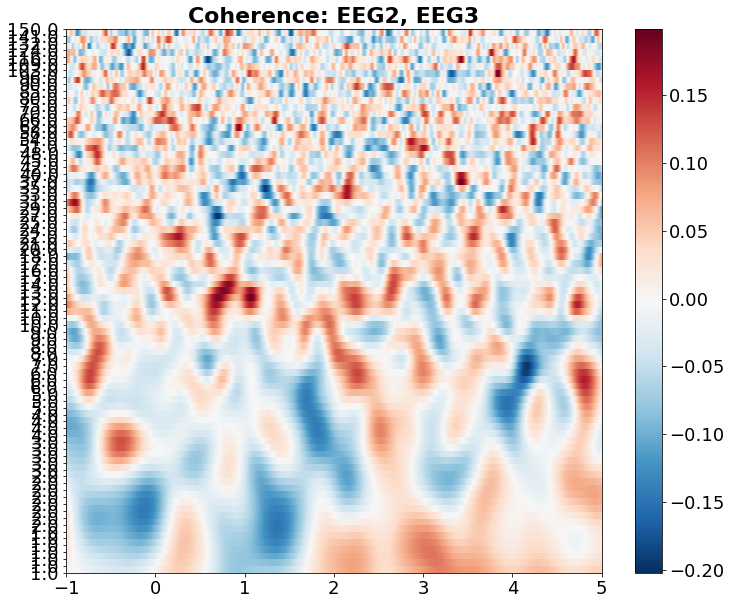

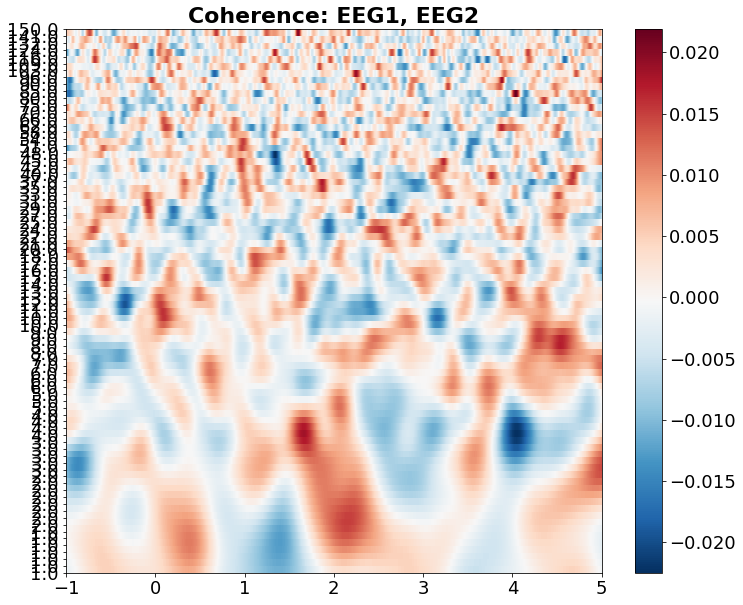

In [109]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 18})



fig, ax = plt.subplots(figsize = (12, 10))
i = ax.imshow(tmp[2, 0, :, 3000:9000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: EEG1, EEG3", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()

fig, ax = plt.subplots(figsize = (12, 10))
i = ax.imshow(tmp[2, 1, :, 3000:9000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: EEG2, EEG3", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()

fig, ax = plt.subplots(figsize = (12, 10))
i = ax.imshow(tmp[1, 0, :, 3000:9000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: EEG1, EEG2", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()





# SLCH002

In [6]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [111]:
## Load Neural Data

# load
trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(trial_onset_epochs.get_annotations_per_epoch()) if  x]

# only good epochs
trial_onset_epochs = trial_onset_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif ...


/tmp/ipykernel_130796/460025053.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  trial_onset_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_ieeg.fif")


    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-1.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_clean_pres-locked_ieeg-2.fif ...
    Found the data of interest:
        t =   -4000.00 ...   12000.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [8]:
trial_onset_epochs._data.shape

(163, 165, 32001)

In [112]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
ROIs = {
    'hc'     :['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'K7'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B5', 'B6', 'B7', 'B8', 'B9'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5'],
    'insula' :['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E2', 'E3', 'E4', 'F1', 'F2', 'F3'],
    'cing'   :['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'],
    'ec'     :['H1', 'H2', 'H3', 'H4', 'L1', 'L2', 'L3', 'L4'], 
    'dlpfc'  :['C11', 'C12', 'C13', 'C14', 'C15', 'C16'] 
}

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in trial_onset_epochs.info['ch_names']]
bidx = len(trial_onset_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(trial_onset_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [113]:
hc_list

['J4-J5',
 'J5-J6',
 'J6-J7',
 'K1-K2',
 'K2-K3',
 'K3-K4',
 'K4-K5',
 'K5-K6',
 'K6-K7',
 'K7-K8']

In [114]:
# only ROI of interest
trial_onset_roi = trial_onset_epochs.copy().pick_channels(hc_list)


In [115]:
# Resample to 1000 
if trial_onset_roi.info['sfreq'] > 1000:
    trial_onset_roi= trial_onset_roi.resample(1000)

In [116]:
# compute TRF

roi_phase = []
roi_phase = compute_hilbert_phase(trial_onset_roi,freqs,n_cycles)


computing TFR


In [ ]:
roi_mrl = compute_mrl(roi_phase.data)

In [ ]:
with open(f'{subject}_hc_mrl_values.pkl', 'wb') as f:
    # Pickle the numpy array
    pickle.dump(roi_mrl, f)

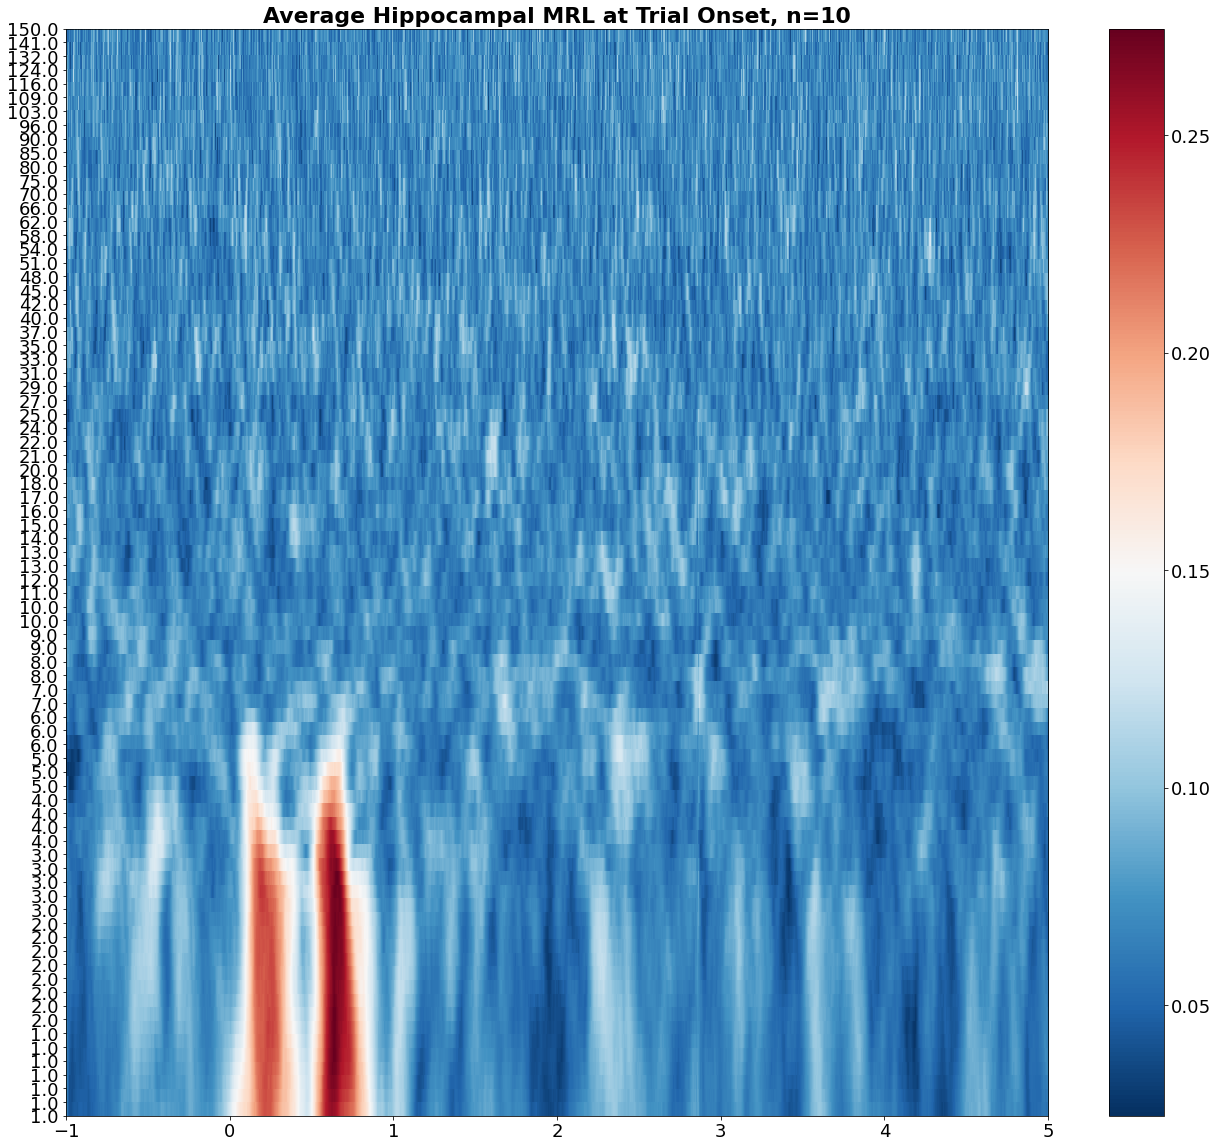

In [ ]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})



fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(roi_mrl.mean(axis = 0), cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-1, 5, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title(f"Average Hippocampal MRL at Trial Onset, n={len(hc_list)}", fontsize=22, fontweight = 'bold')
fig.savefig(f'phase/{subject}_mrl_hc_trialonset.png', dpi=600)
fig.show()
